# Setup

Setup the environment

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive/My Drive/AN2DL/Progetto_2/

/gdrive/My Drive/AN2DL/Progetto_2


## Import Libraries

Import all main libraries

In [ ]:



import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)




2.7.0
(68528, 7)


## Set Seed

Set seed for the environment

In [ ]:
# Random seed for reproducibility
seed = 69

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)



## Load Dataset

Load challenge dataset and print some of its basic information (size, labels, head)

In [ ]:
dataset = pd.read_csv('dataset.csv')
print(dataset.shape)
dataset.head()

## Set Hyperparameters


Set the network's hyperparameters

In [ ]:
model_name = "D_MK_Xc"
window = 864
stride = 1
telescope = 864
reg_telescope = 864
epochs = 200*50
batch_size = 512 

# Data Preparation

Prepare the dataset for model training

In [ ]:
# This is the final code, which simply renames the dataset to the training set to make it compatible with the rest of the code (without splitting)
X_train_raw = dataset

print("Shape of training set:", X_train_raw.shape)

In [ ]:
# # This is the code that was initially used in order to split the dataset into training and test sets

# test_size = int(dataset.shape[0]/10)
# X_train_raw = dataset.iloc[:-test_size]
# X_test_raw = dataset.iloc[-test_size:]

# print("Shape of training set:", X_train_raw.shape)
# print("Shape of test set:", X_test_raw.shape)

## Normalize

Normalize the dataset by fitting all
signals into a [0,1] interval

In [ ]:
# Determine max and min for each signal
X_min = dataset.min()
X_max = dataset.max()

# Normalize the training set
X_train_raw = (X_train_raw-X_min)/(X_max-X_min)

In [ ]:
# # Normalize the test set (note that the normalization was carried out only using training set values)

# X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

## Split Into Windows

Split the training set into windows

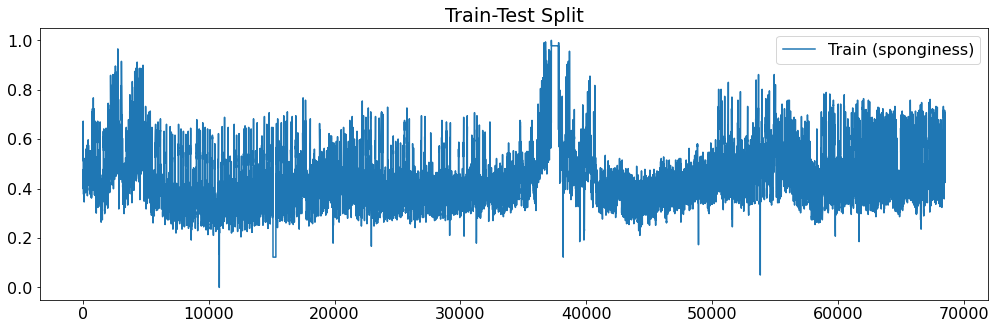

In [ ]:

# Function that carries out the splitting (taken from the exercise session)

def build_sequences(df, target_labels=['sponginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels


In [ ]:
target_labels = dataset.columns
# Split the training set
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
print("Training set shape after splitting:", X_train.shape, y_train.shape)



In [ ]:
# Compute input and output shapes
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
print("Input shape:", input_shape)
print("Output shape:", output_shape)

In [ ]:
# # Split the test set

# X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)

# print("Test set shape after splitting:", X_test.shape, y_test.shape)

## Build Model

Build the model to be trained (the version used while experimenting with Keras Tuner is also provided below the final version for reference)

In [ ]:
# Function used to build the model
def build_model(input_shape, output_shape):
    outputs = []

    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    x = tfkl.Flatten()(input_layer)
    x = tfkl.Dense(output_shape[-1] * output_shape[-2],kernel_initializer=tfk.initializers.HeUniform(seed))(x)
    x = tfkl.PReLU()(x)

    
    
    output_layer =  tfkl.Reshape(output_shape)(x)
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    #Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=tf.keras.metrics.RootMeanSquaredError())

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 864, 7)]          0         
                                                                 
 flatten (Flatten)           (None, 6048)              0         
                                                                 
 dense (Dense)               (None, 6048)              36584352  
                                                                 
 p_re_lu (PReLU)             (None, 6048)              6048      
                                                                 
 reshape (Reshape)           (None, 864, 7)            0         
                                                                 
Total params: 36,590,400
Trainable params: 36,590,400
Non-trainable params: 0
_________________________________________________________________


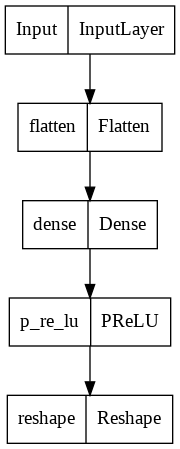

In [ ]:
# Build the model
model= build_model(input_shape, output_shape)

# Print model summary
model.summary()

# Plot the model structure

tfk.utils.plot_model(model, expand_nested=True)



## Train Model

Train the model with the selected parameters

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10*50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5*50, factor=0.7, min_lr=1e-5)
    ]
).history

Epoch 1/10000
30/30 [==============================] - 3s 37ms/step - loss: 0.2409 - root_mean_squared_error: 0.4908 - val_loss: 0.0441 - val_root_mean_squared_error: 0.2100 - lr: 0.0010
Epoch 2/10000
30/30 [==============================] - 1s 26ms/step - loss: 0.0244 - root_mean_squared_error: 0.1563 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1494 - lr: 0.0010
Epoch 3/10000
30/30 [==============================] - 1s 27ms/step - loss: 0.0185 - root_mean_squared_error: 0.1361 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1459 - lr: 0.0010
Epoch 4/10000
30/30 [==============================] - 1s 27ms/step - loss: 0.0178 - root_mean_squared_error: 0.1334 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1444 - lr: 0.0010
Epoch 5/10000
30/30 [==============================] - 1s 26ms/step - loss: 0.0174 - root_mean_squared_error: 0.1318 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1431 - lr: 0.0010
Epoch 6/10000
30/30 [==============================] - 1s 27ms/st

## Save Model

Save the trained model

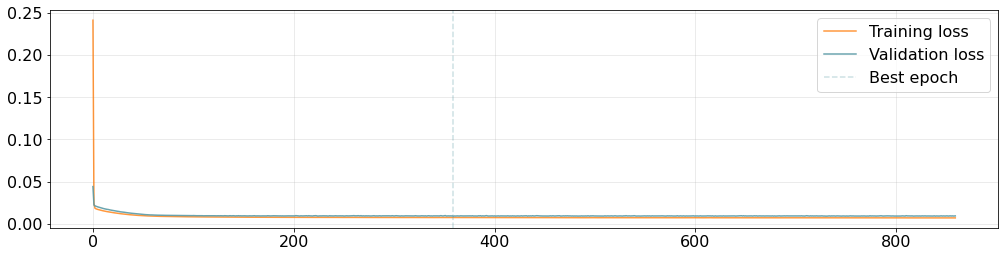

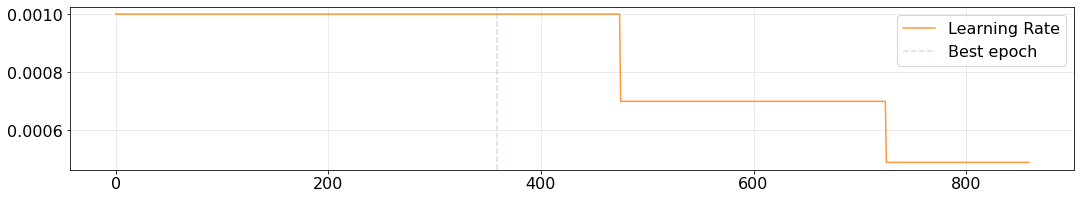

In [ ]:
model.save(model_name)

## Plot Metrics

Plot values of metrics throughout training process

In [ ]:
# Extract best epoch from training history
best_epoch = np.argmin(history['val_loss'])

In [ ]:
# Plot training and validation loss (MSE)
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()